In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import pandas as pd
# Load JSON data from a file into a dictionary
df = pd.read_csv("results/csv/IU_CFS_posts_Jun_Feb.csv")
df = df.fillna("")
# Display the dictionary

In [3]:
data = df.to_dict('records')

In [ ]:
from backend.extractor.task.llm_downstream_utils import get_summarize_prompt, llm_get_tags

# Word Cloud

2024-07-21 20:06:52,063 - nlp_tasks.py: prepare_word_cloud(): 97:	Preprocessing data
--------
2024-07-21 20:06:56,555 - nlp_tasks.py: create_word_cloud(): 35:	done prepare
--------
2024-07-21 20:06:56,556 - nlp_tasks.py: draw_word_cloud(): 56:	Generating word cloud
--------
2024-07-21 20:06:56,889 - nlp_tasks.py: draw_word_cloud(): 76:	Drawn word cloud
--------


'results/word_cloud/wordcloud_73549201-cfd0-4962-8657-4fbb57b5d068.png'

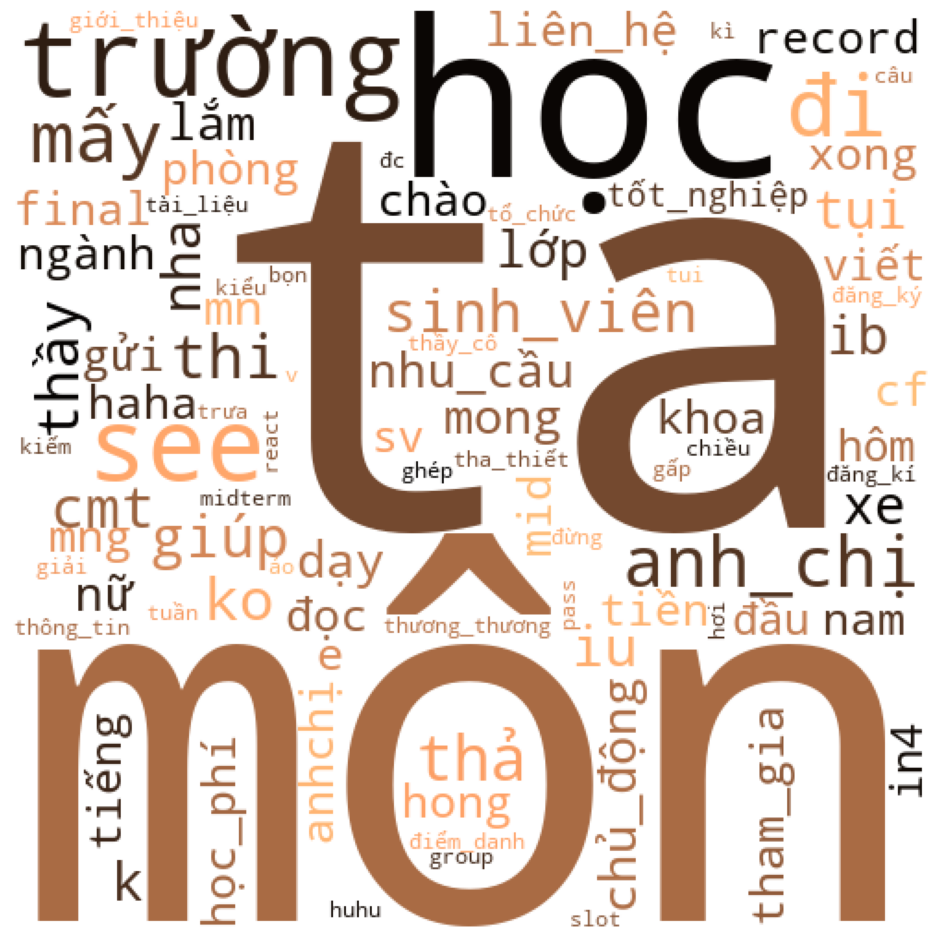

In [8]:
# corpus, stopwords = prepare_word_cloud(data, selected_columns=["article"], fixed_words=["giáo dục và đào tạo", "đại học quốc gia hà nội", "đại học quốc gia tphcm", "đhqg tphcm", "đại học qg tp hcm", "đại học quốc gia tphcm", "phổ thông năng khiếu"])
from backend.extractor.task.nlp_tasks import create_word_cloud

create_word_cloud(
    data, colormap="copper", selected_columns=["content"], regex_patterns=[
    r"#iu_\w+",
    r"\d{2}/\d{2}/\d{4} \d{2}:\d{2}:\d{2}",
    r"[-~_][\w\s]*?[-~_]",
    r"[^\w\s]",
    r"sua dua",
], fixed_words=["phòng công tác sinh viên, điểm rèn luyện"], save=True, max_words=80,
)

# LLM Classify

In [5]:
from backend.extractor.task.llm_utils import llm_extract_task

/Users/minhphan/anaconda3/envs/thesis-3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [52]:
import asyncio
from time import time
from backend.llm.utils import parse_llm_response_data
from backend.logger import get_logger
from backend.llm.llm import LLM
from backend.extractor.task.llm_utils import llm_task


logger = get_logger()
tasks = f"""{{
             "tags": "List 2 - 4 news categories that this article might belong to, separate each categories by a comma, remove list [] and string ' ' syntax"
             "mentions": "List all name of people, subjects, organizations, that the text mentions in keywords, remove list [] and string ' ' syntax",
             }}"""


def get_task_dict(task):
    if isinstance(task, dict):
        task_dict = task
    else:
        task_dict = json.loads(task)
    res = {}
    for key in task_dict.keys():
        res[key] = ""
    return res


# async def llm_extract_task(data, llm_task_format, columns=None, batch_size=12, delay=65):
#     to_classify = []
#     logger.info("Getting texts")
#     if len(columns) == 0:
#         selected_columns = list(data[0].keys())
#     else: selected_columns = columns

#     for row in data:
#         text = "\n".join(value for key, value in row.items() if key in selected_columns)
#         to_classify.append(text)

#     def chunks(data, batch_size):
#         for i in range(0, len(data), batch_size):
#             yield data[i : i + batch_size]

#     batches = list(chunks(to_classify, batch_size))
#     print(batches)
#     responses = []
#     for i, batch in enumerate(batches):
#         logger.info(f"Processing batch number: {i + 1}")
#         tasks = [llm_task(text, llm_task_format) for text in batch]
#         try:
#             batch_responses = await asyncio.gather(*tasks, return_exceptions=True)
#             for response in batch_responses:
#                 if isinstance(response, Exception):
#                     print("Successful response")
#                     responses.append(response)
#                     print(response)
#                 else:
#                     print(response)
#                     responses.append(response)
#         except Exception as e:
#             print(f"Error processing batch number: {i + 1}, Error: {e}")
#             # If the whole batch fails, add empty responses for the entire batch
#             # responses.extend([get_task_dict(llm_task_format) for _ in batch])
#         finally:
#             if i < len(batches) - 1:
#                 await asyncio.sleep(delay)
#     return responses

# llm_responses = await llm_extract_task(data[0:3], tasks, columns=["article"], batch_size=10)

In [12]:
type(llm_responses[0]["tags"])

str

In [9]:
def combine_res(data, responses, tasks):
    for record, response in zip(data, responses):
        if isinstance(response, dict):
            record.update(response)
        else:
            record.update(get_task_dict(tasks))

    return data

In [10]:
!pip freeze | grep google-generativeai

google-generativeai==0.7.2


In [11]:
import sys
from frontend.pages.utils import handle_llm_task


def combine_res(data, responses, tasks):
    for record, response in zip(data, responses):
        if isinstance(response, dict):
            record.update(response)
        else:
            record.update(get_task_dict(tasks))

        return data


def get_task_dict(task):
    res = {}
    for key in task.keys():
        res[key] = ""
    return res


# async def llm_classify_task(data, tasks, columns):
    # data.fillna("")
    # dictionaries = data.to_dict("records")
    # selected_columns = columns.split(",")
    # selected_columns = (
    #     [col.strip() for col in selected_columns] if columns != "" else []
    # )
    # print(selected_columns)
    # responses = await llm_extract_task(dictionaries, tasks, columns)
    # result = combine_res(dictionaries, responses, tasks)
    # df = pd.DataFrame(result)
    # return df
tasks = {"tags": "List 2 - 4 news categories that this article might belong to, separate each categories by a comma, remove list [] and string ' ' syntax"}
#          "mentions": "List all name of people, subjects, organizations, that the text mentions in keywords, remove list [] and string ' ' syntax"}
result_df = await handle_llm_task(pd.read_csv("results/csv/vnexpress_thegioi_24_6.csv")[0:3], tasks, columns="description")

2024-07-17 01:56:16,214 - llm_utils.py: llm_extract_task(): 79:	Getting texts
--------
2024-07-17 01:56:16,215 - llm_utils.py: llm_extract_task(): 98:	Processing batch number: 1
--------


{'tags': "List 2 - 4 news categories that this article might belong to, separate each categories by a comma, remove list [] and string ' ' syntax"} <class 'dict'>
['description']
[['Giới chức bang Tamil Nadu ở miền nam Ấn Độ thông báo 53 người chết vì uống rượu pha cồn công nghiệp methanol, một loại chất độc.', 'Phán quyết "có tội" ở New York sẽ khiến các vụ truy tố còn lại của ông Trump trở nên phức tạp hơn, nhưng ông nhiều khả năng không bị xét xử thêm trước ngày bầu cử.', 'Bất đồng liên quan gói vũ khí viện trợ của Mỹ cho Israel khiến Tel Aviv và Washington chỉ trích lẫn nhau, gia tăng rạn nứt giữa hai đồng minh.']]
{"tags": "List 2 - 4 news categories that this article might belong to, separate each categories by a comma, remove list [] and string ' ' syntax"}
{'tags': 'Tin tức pháp lý, Chính trị, Hoa Kỳ, Bầu cử'}
{'tags': 'Chính trị quốc tế, Quan hệ quốc tế, Quân sự, Tin tức thế giới'}
{'tags': 'Tin tức, Thế giới, An ninh, Sức khỏe'}


In [9]:
result_df

,title,description,article,date,topic,tags
0,Hơn 50 người Ấn Độ chết vì ngộ độc rượu,Giới chức bang Tamil Nadu ở miền nam Ấn Độ thô...,Vụ ngộ độc xảy ra ngày 18/6 khiến hơn 100 ngườ...,"Chủ nhật, 23/6/2024, 20:30 (GMT+7)",NaN,"Tin tức, Thế giới, An ninh, Y tế"
1,Tương lai ba vụ truy tố ông Trump sau phán quy...,"Phán quyết ""có tội"" ở New York sẽ khiến các vụ...","Vài tháng trước, nhiều người nghĩ rằng cựu tổn...","Chủ nhật, 23/6/2024, 19:00 (GMT+7)",Ông Trump bị truy tố ở New York Kết tội Phiên ...,"Tin tức pháp lý, Chính trị, Hoa Kỳ, Bầu cử"
2,Bất đồng về vũ khí khoét sâu rạn nứt Mỹ - Israel,Bất đồng liên quan gói vũ khí viện trợ của Mỹ ...,Thủ tướng Israel Benjamin Netanyahu trong vide...,"Thứ hai, 24/6/2024, 00:00 (GMT+7)",NaN,"Chính trị quốc tế, Quan hệ quốc tế, Quân sự, N..."


In [12]:
response

{'mentions': '["NEET-UG", "Ấn Độ", "NTA", "Dharmendra Pradhan", "S. V. Bhatti", "Narendra Modi", "Mallikarjun Kharge", "INC", "Surbhi Sharma", "Vivek Pandey", "Bihar", "Manavjit Singh Dhillon", "BJP", "Godhra", "Rajasthan", "Delhi"]',
 'tags': '["Giáo dục", "Kỳ thi", "Ấn Độ", "Y tế", "Lộ đề", "Gian lận", "Tòa án", "Điều tra", "Bất thường", "Cáo buộc", "Phản đối", "Chính trị"]'}